In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/balanced_user_engagement_dataset.csv")

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(df["truth"])

# Select features (excluding username)
X = df.drop(columns=["username", "truth"]).values

# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for CNN+LSTM (samples, time_steps=1, features)
X = X.reshape(X.shape[0], 1, X.shape[1])  # (n_samples, 1, 14)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

model = Sequential([
    # CNN for feature extraction
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, 14)),
    MaxPooling1D(pool_size=1),  # No pooling needed for single timestep
    Dropout(0.3),

    # LSTM for sequence learning
    LSTM(100, return_sequences=False),  # Single LSTM layer
    Dropout(0.3),

    # Classifier
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 output classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,684 (287.83 KB)

 Trainable params: 73,684 (287.83 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.7075 - loss: 0.8059 - val_accuracy: 0.8631 - val_loss: 0.4926
Epoch 2/20
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.8429 - loss: 0.5301 - val_accuracy: 0.8793 - val_loss: 0.4516
Epoch 3/20
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.8694 - loss: 0.4763 - val_accuracy: 0.8980 - val_loss: 0.4226
Epoch 4/20
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.8884 - loss: 0.4382 - val_accuracy: 0.9056 - val_loss: 0.4019
Epoch 5/20
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8958 - loss: 0.4255 - val_accuracy: 0.9058 - val_loss: 0.3986
Epoch 6/20
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9010 - loss: 0.4139 - val_accuracy: 0.9114 - val_loss: 0.3881
Epoch 7/20
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9047 - loss: 0.4048 - val_accuracy: 0.9106 - val_loss: 0.3889
Epoch 8/20
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9050 - loss: 0

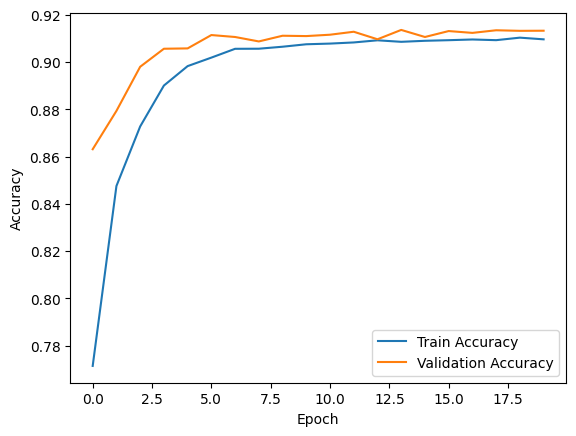

Test Accuracy: 0.9133


In [9]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Test evaluation
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

In [10]:
# Predict class probabilities
y_probs = model.predict(X_test[:5])  # First 5 samples

# Convert to class labels
y_pred = np.argmax(y_probs, axis=1)
print("Predicted Classes:", encoder.inverse_transform(y_pred))
print("True Classes:", encoder.inverse_transform(y_test[:5]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Predicted Classes: ['Distinction' 'Fail' 'Distinction' 'Dropout' 'Fail']
True Classes: ['Distinction' 'Distinction' 'Distinction' 'Dropout' 'Fail']


In [11]:
# Assuming 'model' is your trained Keras model
model.save("my_model_balanced.h5")


In [12]:
model.save("my_model_balanced_keras.keras")


In [ ]:
from keras.layers import Bidirectional, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

model=Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True),input_shape=(1,14)))
model.add(Bidirectional(GRU(128,return_sequences=False))),
model.add(Dense(128,activation='relu')),
model.add(Dense(128,activation='relu')),
model.add(Dense(4,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       146,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 492,804 (1.88 MB)

 Trainable params: 492,804 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history_Bi=model.fit(X_train,y_train,epochs=10,batch_size=32,validation_data=(X_test,y_test),verbose=1)

Epoch 1/10
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.8047 - loss: 0.6248 - val_accuracy: 0.8846 - val_loss: 0.4483
Epoch 2/10
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - accuracy: 0.8876 - loss: 0.4436 - val_accuracy: 0.8846 - val_loss: 0.4541
Epoch 3/10
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8950 - loss: 0.4246 - val_accuracy: 0.8978 - val_loss: 0.4171
Epoch 4/10
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9016 - loss: 0.4056 - val_accuracy: 0.8962 - val_loss: 0.4230
Epoch 5/10
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9000 - loss: 0.4127 - val_accuracy: 0.9044 - val_loss: 0.4039
Epoch 6/10
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9048 - loss: 0.4005 - val_accuracy: 0.9001 - val_loss: 0.4148
Epoch 7/10
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9069 - loss: 0.3926 - val_accuracy: 0.9041 - val_loss: 0.4022
Epoch 8/10
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.9067 - loss: 0

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Test evaluation
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

NameError: name 'history' is not defined

In [ ]:
# Predict class probabilities
y_probs = model.predict(X_test[:5])  # First 5 samples

# Convert to class labels
y_pred = np.argmax(y_probs, axis=1)
print("Predicted Classes:", encoder.inverse_transform(y_pred))
print("True Classes:", encoder.inverse_transform(y_test[:5]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicted Classes: ['Distension' 'Fail' 'Distension' 'Dropout' 'Fail']
True Classes: ['Distension' 'Distension' 'Distension' 'Dropout' 'Fail']
